In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
tf.__version__

'2.12.0'

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 100
CHANNELS=3
EPOCHS=25

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Ved1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15339 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['0', '1', '2', '3', '4', '5', '6']

In [6]:
len(dataset)

120

In [7]:
120*128

15360

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(128, 100, 100, 3)
[3 3 3 0 6 3 3 3 5 4 0 6 2 4 5 4 6 3 0 3 6 6 6 5 3 4 4 6 3 4 6 3 4 2 4 3 3
 6 3 5 2 4 6 3 3 3 3 2 1 5 3 3 3 6 6 0 6 6 6 2 2 3 3 4 3 3 3 3 2 3 3 6 0 3
 3 6 0 6 0 3 4 4 1 3 3 3 3 6 3 1 3 6 3 4 6 4 3 0 0 4 3 0 6 6 6 6 3 3 0 3 2
 6 6 4 2 2 3 3 2 6 3 3 4 3 3 5 3 6]


In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[126.  66.  40.]
  [128.  68.  42.]
  [133.  71.  46.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[131.  69.  44.]
  [134.  72.  47.]
  [138.  76.  51.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[139.  75.  48.]
  [143.  79.  52.]
  [148.  84.  57.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 ...

 [[157. 104.  72.]
  [158. 105.  73.]
  [159. 106.  74.]
  ...
  [  4.   4.   6.]
  [  4.   4.   6.]
  [  7.   7.   9.]]

 [[155. 102.  70.]
  [154. 101.  69.]
  [153. 100.  68.]
  ...
  [  8.   8.  10.]
  [  5.   5.   7.]
  [  7.   7.   9.]]

 [[154. 101.  69.]
  [152.  99.  67.]
  [151.  98.  66.]
  ...
  [ 12.  12.  14.]
  [  8.   8.  10.]
  [  8.   8.  10.]]]


In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(100, 100, 3)


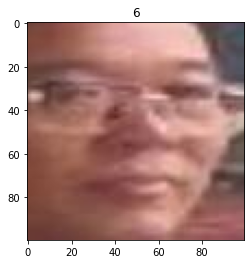

In [11]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
#     plt.axis("off")

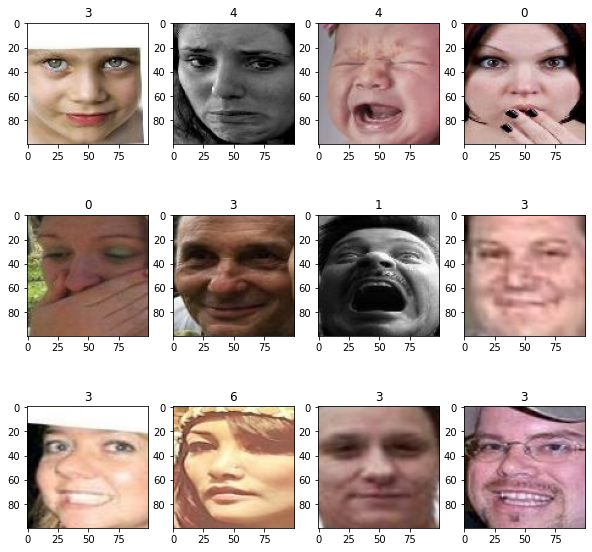

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
#         plt.axis("off")


In [13]:
len(dataset)

120

In [14]:

train_size = 0.8
len(dataset)*train_size

96.0

In [15]:
train_ds = dataset.take(96)
len(train_ds)

96

In [16]:
test_ds = dataset.skip(96)
len(test_ds)

24

In [17]:
val_size=0.1
len(dataset)*val_size

12.0

In [18]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [19]:
test_ds = test_ds.skip(12)
len(test_ds)

12

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

96

In [23]:
len(val_ds)

12

In [24]:
len(test_ds)

12

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 100, 100, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 98, 98, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (128, 49, 49, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 47, 47, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 23, 23, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (128, 21, 21, 64)        

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
96/96 [==============================] - 394s 4s/step - loss: 1.5244 - accuracy: 0.4375 - val_loss: 1.2016 - val_accuracy: 0.5527
Epoch 2/25
96/96 [==============================] - 361s 4s/step - loss: 1.1237 - accuracy: 0.6033 - val_loss: 0.9098 - val_accuracy: 0.6732
Epoch 3/25
96/96 [==============================] - 321s 3s/step - loss: 0.9438 - accuracy: 0.6672 - val_loss: 0.7989 - val_accuracy: 0.7161
Epoch 4/25
96/96 [==============================] - 349s 4s/step - loss: 0.8208 - accuracy: 0.7161 - val_loss: 0.6751 - val_accuracy: 0.7702
Epoch 5/25
96/96 [==============================] - 366s 4s/step - loss: 0.7409 - accuracy: 0.7395 - val_loss: 0.6097 - val_accuracy: 0.7839
Epoch 6/25
96/96 [==============================] - 361s 4s/step - loss: 0.6724 - accuracy: 0.7660 - val_loss: 0.5788 - val_accuracy: 0.8066
Epoch 7/25
96/96 [==============================] - 279s 3s/step - loss: 0.6204 - accuracy: 0.7832 - val_loss: 0.5101 - val_accuracy: 0.8229
Epoch 8/25
96

In [31]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 86s 2s/step - loss: 0.3289 - accuracy: 0.9290


In [32]:
scores

[0.3288862705230713, 0.9290364384651184]

In [33]:

history

In [34]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 96}

In [35]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:

type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

25

In [38]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5244300365447998,
 1.1237388849258423,
 0.9438387751579285,
 0.8208371996879578,
 0.7409098744392395]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

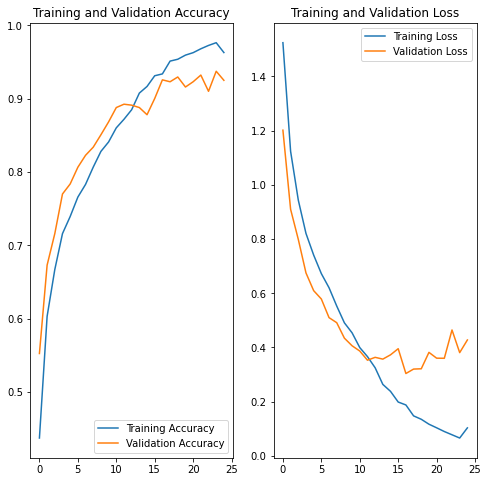

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 0
4/4 [==============================] - 9s 621ms/step
predicted label: 0


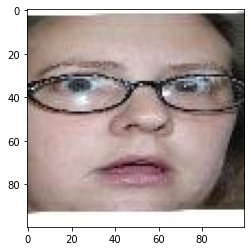

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 441ms/step


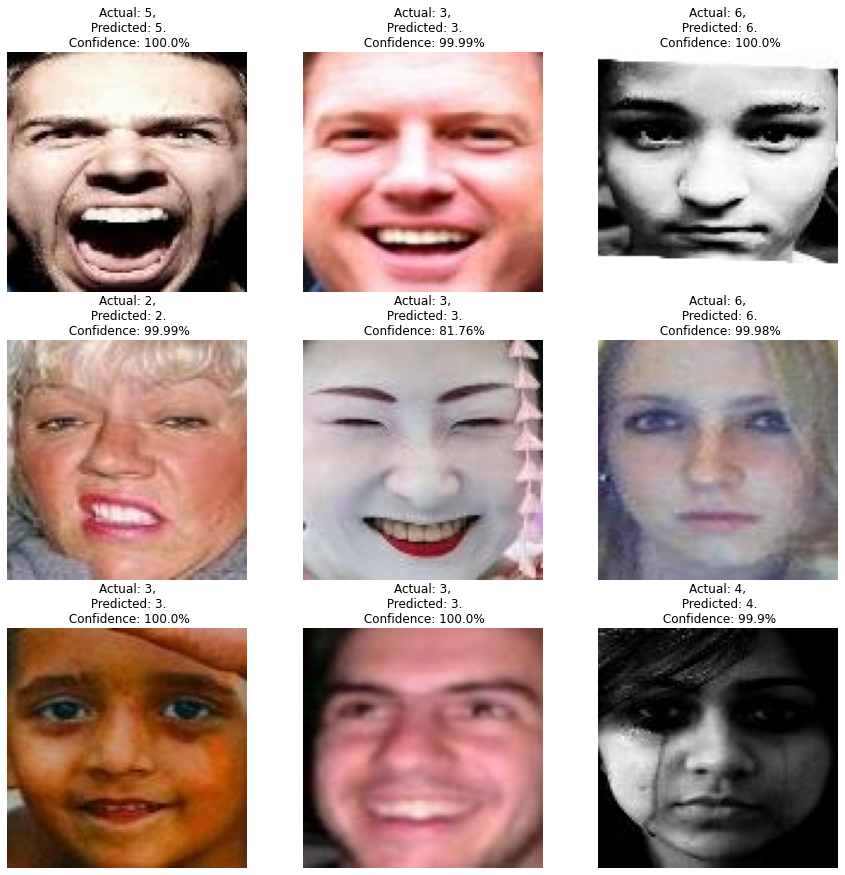

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"C:/Users/HARSHAL/models/{model_version}")

ValueError: invalid literal for int() with base 10: '3.zip'

In [45]:

model.save("A-98-VA-92-RAF-BS-128-1Layer removed-E-25.h5")

In [46]:
model = tf.keras.models.load_model("A-98-VA-92-RAF-BS-128-1Layer removed-E-25.h5")

first image to predict
actual label: 3
4/4 [==============================] - 2s 238ms/step
predicted label: 3


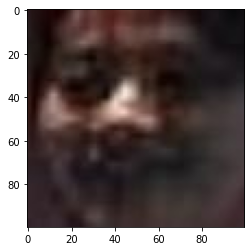

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [49]:
# plt.figure(figsize=(15, 15))
# count=0
# # for j in range(48):
#     for images, labels in test_ds.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             predicted_class, confidence = predict(model, images[i].numpy())
#             actual_class = class_names[labels[i]] 
#             if(predicted_class==actual_class):
#                 count=count+1;
# ta=count/(1536)
# print("Testing Accuracy of our model is =>",ta)
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
#         plt.axis("off")
count=0
total=0
plt.figure(figsize=(15, 15))
# for j in range(2):
for images, labels in test_ds.take(12):
    for i in range(128):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        if(predicted_class==actual_class):
            count=count+1
        total=total+1
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

#         plt.axis("off")

ta=count/(total) 
print("Total testing images =>",total)
print("Testing Accuracy of our model is =>",ta)

1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 383ms/step
Total testing images => 1536
Testing Accuracy of our model is => 0.9290364583333334


<Figure size 1080x1080 with 0 Axes>

In [50]:
len(test_ds)

12

In [51]:
12*128

1536

In [52]:
ta=count/(total)
print("Testing Accuracy of our model is =>",ta)

Testing Accuracy of our model is => 0.9290364583333334
